/Users/laundal/opt/anaconda3/envs/py38/lib/python3.8/site-packages/matplotlib/contour.py:1491: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/laundal/opt/anaconda3/envs/py38/lib/python3.8/site-packages/matplotlib/contour.py:1492: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


IntSlider(value=0, max=360, step=0)

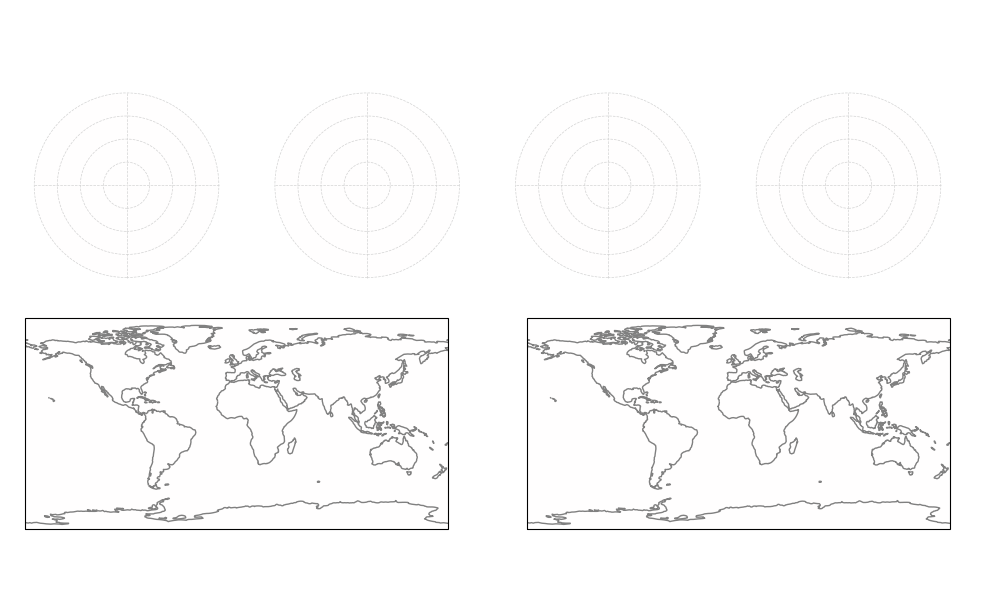

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pynamit
from polplot import Polarplot
import xarray as xr
import pandas as pd
import warnings
import ipywidgets as widgets
from IPython.display import display
RE = pynamit.constants.RE
mu0 = pynamit.constants.mu0

warnings.filterwarnings("ignore", message="No contour levels were found within the data range.")


B_kwargs   = {'cmap':plt.cm.bwr, 'levels':np.linspace(-100, 100, 22) * 1e-9, 'extend':'both'}
eqJ_kwargs = {'colors':'black', 'levels':np.r_[-210:220:20] * 1e3}
FAC_kwargs = {'cmap':plt.cm.bwr, 'levels':np.linspace(-.95, .95, 22)/6 * 1e-6, 'extend':'both'}
Phi_kwargs = {'colors':'black', 'levels':np.r_[-212.5:220:5] * 1e3}
EW_kwargs  = {'colors':'green', 'levels':Phi_kwargs['levels']/4}


%matplotlib widget

data = xr.load_dataset('flareish.ncdf')
# Convert the 'time' coordinate to a pandas Series
time_series = pd.Series(data['time'].values)
# Get the indices of unique times
unique_indices = ~time_series.duplicated(keep='first')
# Select the data using these indices
data = data.isel(time=unique_indices)


# conversion factors:
VB_to_Br     = -data.n
laplacian    = -data.n * (data.n + 1) / data.RI**2
TB_to_Jr     =  laplacian * data.RI / mu0
EW_to_dBr_dt = -laplacian * data.RI
VB_to_Jeq    =  data.RI / mu0 * (2 * data.n + 1) / (data.n + 1)



B0_parameters = {'epoch':data.mainfield_epoch, 'hI':(data.RI - RE) * 1e-3}
mainfield = pynamit.Mainfield(kind = data.mainfield_kind, **B0_parameters)
sh_basis = pynamit.SHBasis(data.N, data.M)


lat, lon = np.linspace(-89.9, 89.9, 60), np.linspace(-180, 180, 100)
lat, lon = np.meshgrid(lat, lon)
plt_grid = pynamit.grid.Grid(lat, lon)
plt_evaluator = pynamit.basis_evaluator.BasisEvaluator(sh_basis, plt_grid)


## MAP PROJECTION:
global_projection = ccrs.PlateCarree(central_longitude = 0)

fig = plt.figure(figsize = (10, 6))

paxn_imposed = Polarplot(plt.subplot2grid((2, 4), (0, 0)))
paxs_imposed = Polarplot(plt.subplot2grid((2, 4), (0, 1)))
paxn_induced = Polarplot(plt.subplot2grid((2, 4), (0, 2)))
paxs_induced = Polarplot(plt.subplot2grid((2, 4), (0, 3)))
gax_imposed  = plt.subplot2grid((2, 2), (1, 0), projection = global_projection, rowspan = 2)
gax_induced  = plt.subplot2grid((2, 2), (1, 1), projection = global_projection, rowspan = 2)

for ax in [gax_imposed, gax_induced]: 
    ax.coastlines(zorder = 2, color = 'grey')

plt.subplots_adjust(top=0.89, bottom=0.095, left=0.025, right=0.95, hspace=0.0, wspace=0.185)

indexer = data.indexes["time"].get_indexer([0], method = 'nearest')
subset  = data.isel(time = indexer[0])
TB       = subset.SH_coefficients_imposed.values
VB       = subset.SH_coefficients_induced.values
Phi_coef = subset.SH_Phi.values * data.RI
EW_coef  = subset.SH_W.values * data.RI
jr  = plt_evaluator.G.dot(TB * TB_to_Jr) 
jeq = plt_evaluator.G.dot(VB * VB_to_Jeq)
Br  = plt_evaluator.G.dot(VB * VB_to_Br)
Phi = plt_evaluator.G.dot(Phi_coef)
EW  = plt_evaluator.G.dot(EW_coef)


contours = {}
## GLOBAL PLOTS
contours['jr ']  = gax_imposed.contourf(lon, lat, jr .reshape(lon.shape), transform = ccrs.PlateCarree(), **FAC_kwargs)
contours['jeq']  = gax_induced.contour( lon, lat, jeq.reshape(lon.shape), transform = ccrs.PlateCarree(), **eqJ_kwargs)
contours['Br' ]  = gax_induced.contourf(lon, lat, Br .reshape(lon.shape), transform = ccrs.PlateCarree(), **B_kwargs)
contours['Phi']  = gax_imposed.contour( lon, lat, Phi.reshape(lon.shape), transform = ccrs.PlateCarree(), **Phi_kwargs)
contours['EW' ]  = gax_imposed.contour( lon, lat, EW .reshape(lon.shape), transform = ccrs.PlateCarree(), **EW_kwargs)


# north:
nnn = lat >  50
contours['jr_n' ] = paxn_imposed.contourf(lat[nnn], lon[nnn]/15, jr .reshape(lon.shape)[nnn], **FAC_kwargs)
contours['Phi_n'] = paxn_imposed.contour( lat[nnn], lon[nnn]/15, Phi.reshape(lon.shape)[nnn], **Phi_kwargs)
contours['EW_n' ] = paxn_imposed.contour( lat[nnn], lon[nnn]/15, EW .reshape(lon.shape)[nnn], **EW_kwargs)
contours['jeq_n'] = paxn_induced.contour( lat[nnn], lon[nnn]/15, jeq.reshape(lon.shape)[nnn], **eqJ_kwargs)
contours['Br_n' ] = paxn_induced.contourf(lat[nnn], lon[nnn]/15, Br .reshape(lon.shape)[nnn], **B_kwargs)


# south:
sss = lat < -50
contours['jr_s' ] = paxs_imposed.contourf(lat[sss], lon[sss]/15, jr .reshape(lon.shape)[sss], **FAC_kwargs)
contours['Phi_s'] = paxs_imposed.contour( lat[sss], lon[sss]/15, Phi.reshape(lon.shape)[sss], **Phi_kwargs)
contours['EW_s' ] = paxs_imposed.contour( lat[sss], lon[sss]/15, EW .reshape(lon.shape)[sss], **EW_kwargs)
contours['jeq_s'] = paxs_induced.contour( lat[sss], lon[sss]/15, jeq.reshape(lon.shape)[sss], **eqJ_kwargs)
contours['Br_s' ] = paxs_induced.contourf(lat[sss], lon[sss]/15, Br .reshape(lon.shape)[sss], **B_kwargs)



# Define the update function
def update(time):
    global contours
    for contour in contours.values():
        for c in contour.collections:
            c.remove()

    indexer = data.indexes["time"].get_indexer([time], method = 'nearest')
    subset  = data.isel(time = indexer[0])
    TB       = subset.SH_coefficients_imposed.values
    VB       = subset.SH_coefficients_induced.values
    Phi_coef = subset.SH_Phi.values * data.RI
    EW_coef  = subset.SH_W.values * data.RI
    jr  = plt_evaluator.G.dot(TB * TB_to_Jr) 
    jeq = plt_evaluator.G.dot(VB * VB_to_Jeq)
    Br  = plt_evaluator.G.dot(VB * VB_to_Br)
    Phi = plt_evaluator.G.dot(Phi_coef)
    EW  = plt_evaluator.G.dot(EW_coef)

    ## GLOBAL PLOTS
    contours['jr '] = gax_imposed.contourf(lon, lat, jr .reshape(lon.shape), transform = ccrs.PlateCarree(), **FAC_kwargs)
    contours['jeq'] = gax_induced.contour( lon, lat, jeq.reshape(lon.shape), transform = ccrs.PlateCarree(), **eqJ_kwargs)
    contours['Br' ] = gax_induced.contourf(lon, lat, Br .reshape(lon.shape), transform = ccrs.PlateCarree(), **B_kwargs)
    contours['Phi'] = gax_imposed.contour( lon, lat, Phi.reshape(lon.shape), transform = ccrs.PlateCarree(), **Phi_kwargs)
    contours['EW' ] = gax_imposed.contour( lon, lat, EW .reshape(lon.shape), transform = ccrs.PlateCarree(), **EW_kwargs)


    # north:
    contours['jr_n' ] = paxn_imposed.contourf(lat[nnn], lon[nnn]/15, jr .reshape(lon.shape)[nnn], **FAC_kwargs)
    contours['jeq_n'] = paxn_induced.contour( lat[nnn], lon[nnn]/15, jeq.reshape(lon.shape)[nnn], **eqJ_kwargs)
    contours['Br_n' ] = paxn_induced.contourf(lat[nnn], lon[nnn]/15, Br .reshape(lon.shape)[nnn], **B_kwargs)
    contours['Phi_n'] = paxn_imposed.contour( lat[nnn], lon[nnn]/15, Phi.reshape(lon.shape)[nnn], **Phi_kwargs)
    contours['EW_n' ] = paxn_imposed.contour( lat[nnn], lon[nnn]/15, EW .reshape(lon.shape)[nnn], **EW_kwargs)


    # south:
    contours['jr_s' ] = paxs_imposed.contourf(lat[sss], lon[sss]/15, jr .reshape(lon.shape)[sss], **FAC_kwargs)
    contours['jeq_s'] = paxs_induced.contour( lat[sss], lon[sss]/15, jeq.reshape(lon.shape)[sss], **eqJ_kwargs)
    contours['Br_s' ] = paxs_induced.contourf(lat[sss], lon[sss]/15, Br .reshape(lon.shape)[sss], **B_kwargs)
    contours['Phi_s'] = paxs_imposed.contour( lat[sss], lon[sss]/15, Phi.reshape(lon.shape)[sss], **Phi_kwargs)
    contours['EW_s' ] = paxs_imposed.contour( lat[sss], lon[sss]/15, EW .reshape(lon.shape)[sss], **EW_kwargs)

        
    
    fig.canvas.draw_idle()

    
# Create the slider widget
slider = widgets.IntSlider(min = 0, max = data.time.max(), step = np.diff(data.time.values)[0], value=0, )
display(slider)

# Define the function to handle slider value changes
def on_value_change(change):
    update(change['new'])

# Attach the observer to the slider
slider.observe(on_value_change, names='value')

plt.show()


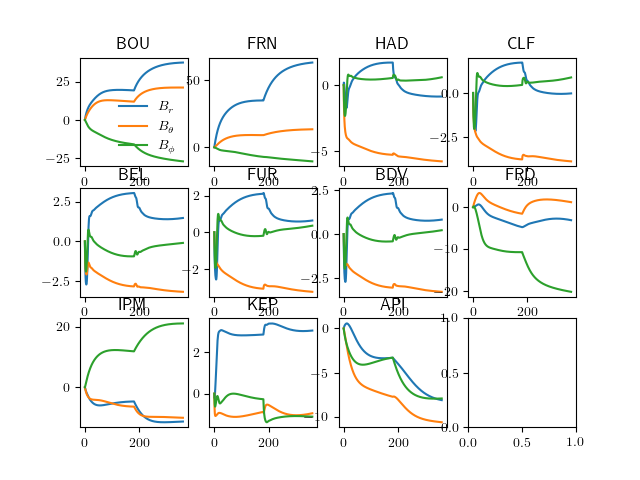

In [5]:
# define magnetometer array:
import pandas as pd
stations = pd.read_csv('hdstations.csv') # a list of some of the 1-sec stations from SuperMAG (there are more!)
glon, glat = stations['GEOLON'].values, stations['GEOLAT'].values

ground_grid = pynamit.grid.Grid(RE, glat, glon, mainfield)
ground_evaluator = pynamit.basis_evaluator.BasisEvaluator(sh_basis, ground_grid)

VB_to_B_h_ground = (RE / data.RI) ** data.n.values
VB_to_B_r_ground = -data.n.values * (RE / data.RI) ** (data.n.values - 1)

# calculate the time series:
VB = data.SH_coefficients_induced.values.T

Br = (ground_evaluator.G   * VB_to_B_r_ground.reshape((1, -1))).dot(VB)
Bh = (ground_evaluator.Gcf * VB_to_B_h_ground.reshape((1, -1))).dot(VB)
Btheta, Bphi = np.split(Bh, 2, axis = 0)

fig, axes = plt.subplots(ncols = 4, nrows = 3)

for i in range(len(stations)):
    ax = axes.flatten()[i]
    ax.plot(data.time.values, Br[i] * 1e9, label = '$B_r$')
    ax.plot(data.time.values, Btheta[i] * 1e9, label = '$B_\\theta$')
    ax.plot(data.time.values, Bphi[i] * 1e9, label = '$B_\phi$')
    ax.set_title(stations.iloc[i].IAGA)

axes[0, 0].legend(frameon = False)

plt.show()